In [1]:
from IPython.display import Image

# Grafos

Um **grafo** é uma estrutura matemática usada para modelar relações entre objetos. Formalmente, um grafo $G$ é definido como um par $G = (V, E)$, onde:

- $V$ é um conjunto de **vértices** (ou nós), que representam os objetos.
- $E$ é um conjunto de **arestas**, que são pares de vértices e representam as conexões entre eles.

Cada aresta $e \in E$ é definida por um par de vértices $(v_i, v_j)$, onde $v_i, v_j \in V$.

### Exemplo matemático
Seja um grafo simples com três vértices $V = \{1, 2, 3\}$ e duas arestas $E = \{(1, 2), (2, 3)\}$, ele pode ser representado da seguinte forma:

- Vértices: $V = \{1, 2, 3\}$
- Arestas: $E = \{(1, 2), (2, 3)\}$

Neste exemplo, os vértices 1 e 2 estão conectados, assim como os vértices 2 e 3.


### Tipos de grafos
- **Grafo não direcionado**: As arestas não têm direção, ou seja, a aresta $(v_i, v_j)$ é equivalente a $(v_j, v_i)$.
- **Grafo direcionado**: As arestas têm direção, de forma que $(v_i, v_j)$ e $(v_j, v_i)$ representam conexões diferentes.


# Matriz de Adjacência

A **matriz de adjacência** é uma maneira de representar grafos utilizando uma matriz quadrada. Para um grafo com $n$ vértices, a matriz de adjacência $A$ será uma matriz $n \times n$, onde cada elemento $A_{ij}$ representa a conexão entre os vértices $i$ e $j$. 

### Definição
- Para um grafo **não direcionado**, $A_{ij} = 1$ se houver uma aresta entre os vértices $i$ e $j$, e $A_{ij} = 0$ caso contrário.
- Para um grafo **direcionado**, $A_{ij} = 1$ indica uma aresta saindo do vértice $i$ e chegando ao vértice $j$.
  
Em um grafo **não ponderado**, os elementos da matriz são binários (0 ou 1). Já em um grafo **ponderado**, $A_{ij}$ pode conter o peso da aresta entre $i$ e $j$.

### Exemplo
Considere o grafo não direcionado com três vértices $V = \{1, 2, 3\}$ e duas arestas $E = \{(1, 2), (2, 3)\}$:

- Vértices: $V = \{1, 2, 3\}$
- Arestas: $E = \{(1, 2), (2, 3)\}$

A matriz de adjacência $A$ para esse grafo seria:

$$
A = \begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$
A matriz de adjacência é uma forma compacta e eficiente de representar as conexões entre vértices em um grafo, e é amplamente utilizada em algoritmos de grafos.

Uma vantagem dos grafos não direcionados é que sua matriz de adjacência é __simétrica__!

A forma com que vamos trabalhar com grafos no Python é via a biblioteca __NetworkX__.

# Exemplo: Dataset Cora

In [2]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

In [3]:
data_path = pathlib.Path("../../data/cora/")

In [4]:
citations = pd.read_csv(
    data_path / "cora.cites",
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]

papers = pd.read_csv(
    data_path / "cora.content", sep="\t", header=None, names=column_names,
)

In [6]:
# papers.head()
papers.head().T

,0,1,2,3,4
paper_id,31336,1061127,1106406,13195,37879
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


In [7]:
papers["term_1430"].unique()

array([0, 1])

In [8]:
papers["subject"].value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [9]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [10]:
papers[papers["paper_id"] == 35]

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
163,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


In [11]:
papers[papers["paper_id"] == 1033]

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
402,1033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


In [12]:
papers[papers["paper_id"] == 1050679]

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
2295,1050679,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


#### Formato dos dados

In [13]:
papers.shape, citations.shape

((2708, 1435), (5429, 2))

#### processamento

In [14]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [15]:
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [16]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [17]:
papers.head().T

,0,1,2,3,4
paper_id,462,1911,2002,248,519
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


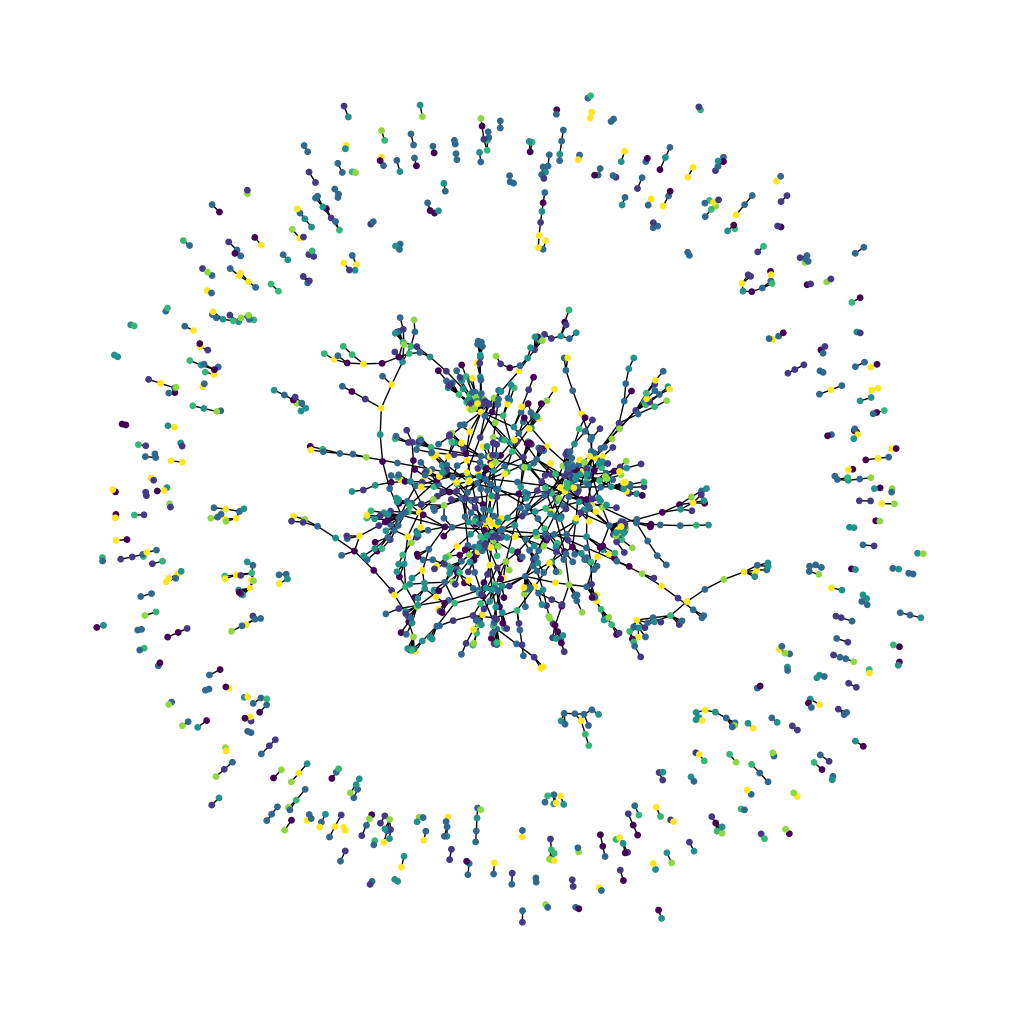

In [18]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1508))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
# nx.draw_circular(cora_graph, node_size=15, node_color=subjects)
# nx.draw_kamada_kawai(cora_graph, node_size=15, node_color=subjects)
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

**Problema: Baseado nos termos de um artigo e nos artigos relacionados, conseguimos prever o seu tópico usando uma rede neural?**

# Uma maneira  de fazer GNNs

## Convolução em Imagens vs. Grafos

A operação de convolução, amplamente utilizada em redes neurais convolucionais (CNNs) para processar imagens, não se adapta diretamente a grafos devido à diferença fundamental entre as estruturas de imagens e grafos.

Em imagens, os pixels estão organizados em uma grade regular e possuem uma vizinhança fixa, permitindo que um filtro de convolução aplique a mesma operação em cada região local da imagem. Essa regularidade facilita o uso de kernels de convolução que capturam padrões como bordas ou texturas.

No entanto, em grafos, os nós (vértices) não estão organizados em uma estrutura fixa e podem ter diferentes números de vizinhos. Cada nó em um grafo pode ter um conjunto variável de conexões (arestas), o que torna impossível aplicar um filtro de convolução fixo, como nas imagens. Além disso, a falta de uma ordem espacial clara nos nós dificulta o uso de operações que dependem dessa regularidade.

Por isso, métodos como as **Graph Neural Networks (GNNs)** utilizam técnicas especializadas para realizar convoluções em grafos, considerando a topologia e as relações entre os nós de maneira mais flexível. Em vez de aplicar filtros fixos, as GNNs aprendem a agregar informações dos vizinhos de cada nó de maneira adaptativa, respeitando a estrutura do grafo.


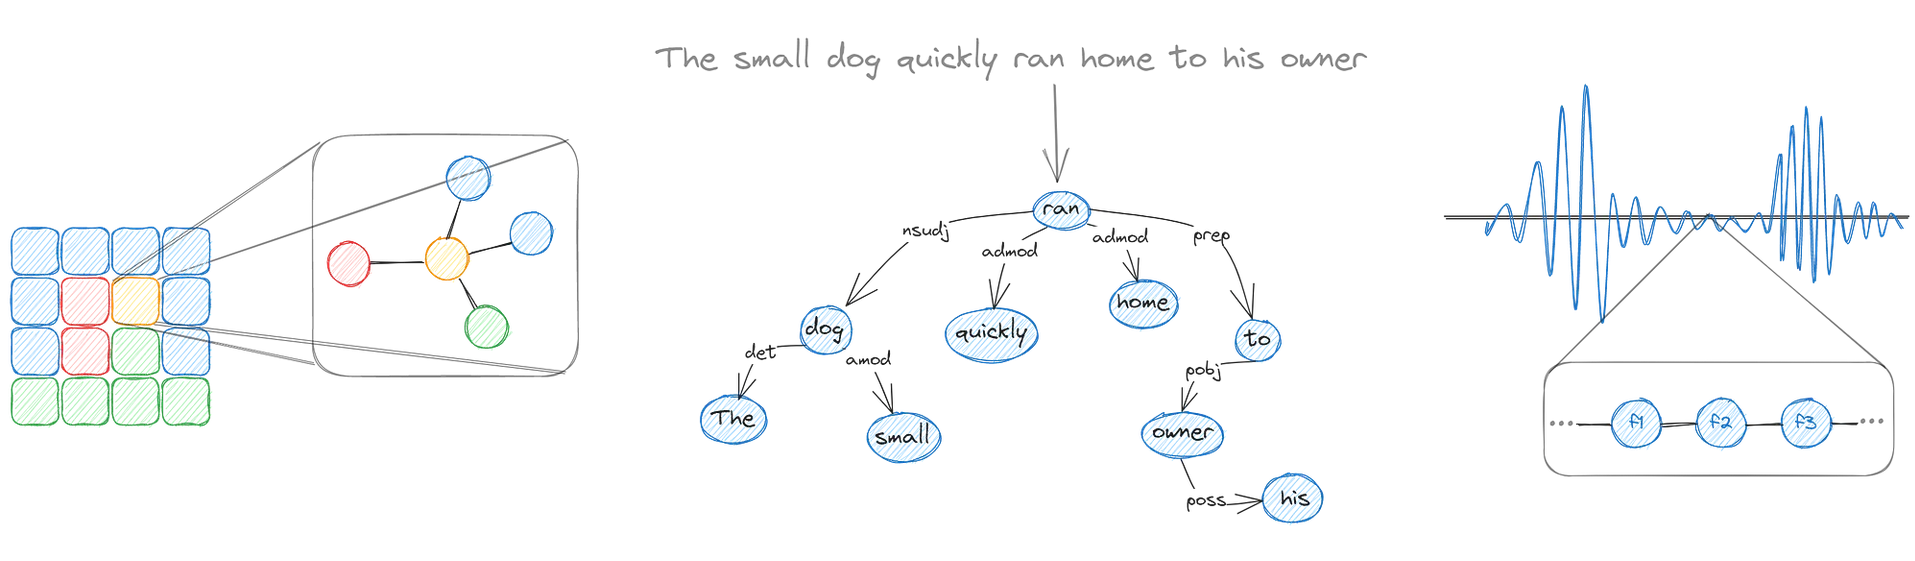

In [19]:
Image(filename='graph_representation.png') 

### Exemplo via NetworkX

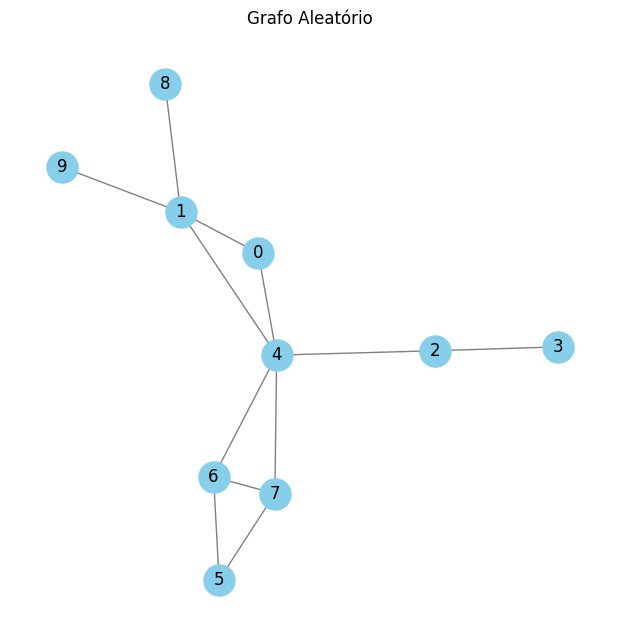

In [20]:
# Gerar um grafo aleatório
G = nx.erdos_renyi_graph(n=10, p=0.3) 

# Plotar o grafo
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Aleatório")
plt.show()

# Uma forma de generalizar Convoluções

## Matriz Laplaciana

A **matriz Laplaciana** de um grafo, denotada como $L$, é uma matriz fundamental em teoria dos grafos, com diversas aplicações em análise de redes e grafos, incluindo detecção de comunidades, fluxos em redes, e aprendizado em grafos. Ela é definida como:

$$
\mathcal{L} = D - A
$$

onde:
- $D$ é a **matriz de grau**, uma matriz diagonal onde cada entrada $D_{ii}$ representa o número de arestas conectadas ao vértice $i$.
- $A$ é a **matriz de adjacência**, que descreve as conexões entre os vértices do grafo, com $A_{ij} = 1$ se existe uma aresta entre os vértices $i$ e $j$, e 0 caso contrário.

A matriz Laplaciana captura a estrutura do grafo, refletindo não apenas a conectividade dos vértices, mas também a distribuição dos graus. Ela possui propriedades interessantes, como o fato de sempre ter pelo menos um autovalor igual a zero (correspondente a uma componente conectada do grafo). A Laplaciana é amplamente usada em algoritmos de aprendizado em grafos e otimização de redes.


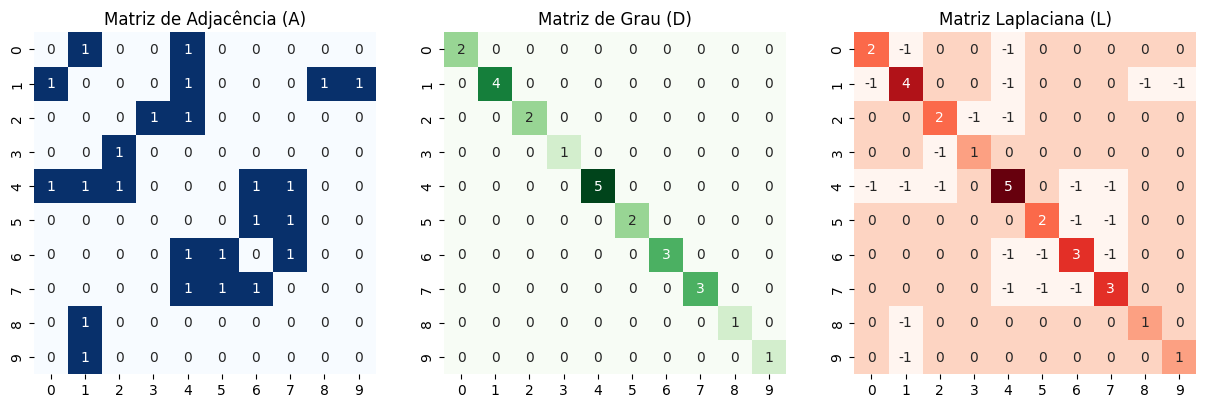

In [21]:
# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Plotar as matrizes como heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Matriz de Adjacência
sns.heatmap(A, ax=axes[0], cmap='Blues', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Adjacência (A)")

# Matriz de Grau
sns.heatmap(D, ax=axes[1], cmap='Greens', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz de Grau (D)")

# Matriz Laplaciana
sns.heatmap(L, ax=axes[2], cmap='Reds', annot=True, cbar=False, square=True)
axes[2].set_title("Matriz Laplaciana (L)")

plt.show()

#### O espectro de L nos dá muita informação!

Podemos decompor $\mathcal{L}$:

$$\mathcal{L} = U \Lambda U^{-1} = U \Lambda U^{\top},$$

onde $U = [u_1,\dots,u_n]$ contém os autovetores de $\mathcal{L}$ e $\Lambda = \text{diag}[\lambda_1,\dots,\lambda_n]$ é uma matriz diagonal contendo seus respectivos autovalores.

__Conseguimos mostrar que $\mathcal{L}$ é simétrica positiva semidefinida!!!__

Essa decomposição é conhecida como **decomposição espectral**. A matriz $U$ é ortogonal, ou seja, $U^{-1} = U^{\top}$, pois a matriz Laplaciana $\mathcal{L}$ é simétrica. A decomposição espectral nos permite entender diversas propriedades do grafo associado. 

- Os autovetores associados aos menores autovalores da matriz Laplaciana capturam informações sobre a **conectividade global** do grafo.
- O **autovalor zero** e seu respectivo autovetor indicam **componentes conectados**. No caso de um grafo conectado, há apenas um autovalor zero, e o vetor associado é constante.
- A matriz diagonal $\Lambda$ contém os **autovalores**, que são indicadores da estrutura do grafo, como a existência de componentes conectados e a robustez da conectividade entre os vértices.

Essa decomposição tem várias aplicações, como a **partição espectral** de grafos, onde os autovetores podem ser usados para agrupar nós em comunidades ou detectar clusters, e em **aprendizado em grafos**, onde essa informação é utilizada em técnicas como a Graph Convolutional Networks (GCN).


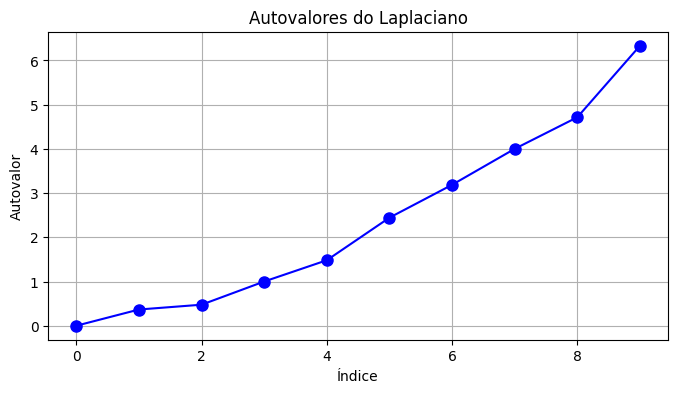

In [22]:
# Autovalores do Laplaciano
eigenvalues = np.linalg.eigvals(L)
eigenvalues_sorted = np.sort(eigenvalues)

# Plotar autovalores
plt.figure(figsize=(8, 4))
plt.plot(eigenvalues_sorted, 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

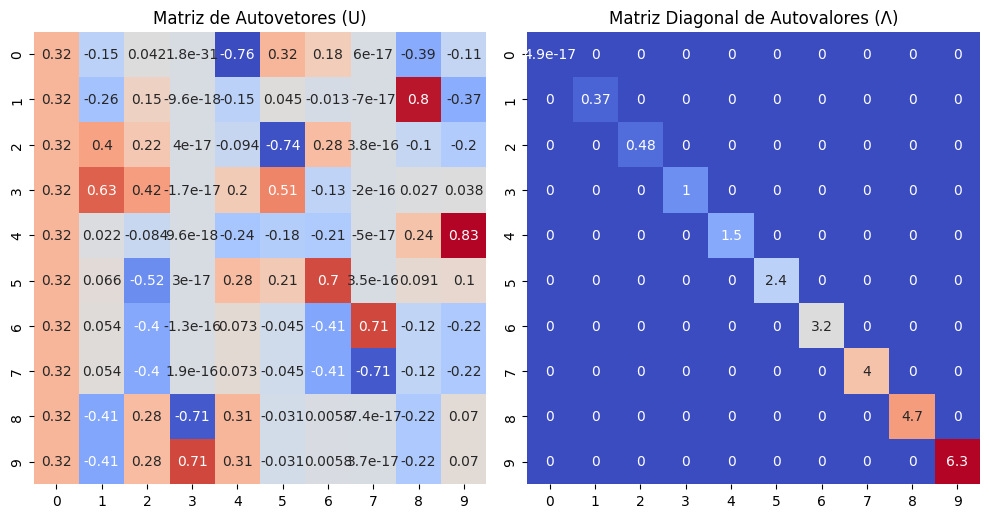

In [23]:
# Calcular autovalores (Lambda) e autovetores (U)
eigenvalues, eigenvectors = np.linalg.eigh(L)  # Use eigh para Laplaciano simétrico

# Criar a matriz diagonal Lambda com os autovalores
Lambda = np.diag(eigenvalues)

# U é a matriz de autovetores (eigenvectors)
U = eigenvectors

# Plotar as matrizes U e Lambda
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot da matriz U (autovetores)
sns.heatmap(U, ax=axes[0], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Autovetores (U)")

# Plot da matriz Lambda (autovalores)
sns.heatmap(Lambda, ax=axes[1], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz Diagonal de Autovalores (Λ)")

plt.tight_layout()
plt.show()

### Autovalores e componentes conexas

Os autovalores de $\mathbf{L}$ fornecem informações ainda mais significativas do que o esperado. Por exemplo, ao ordenar e rotular os autovalores de modo que $\lambda_1$ corresponda ao menor autovalor, observa-se que este valor é sempre zero. Esta ocorrência não é acidental; a multiplicidade do autovalor zero está associada ao número de componentes conexas no grafo. Especificamente, se $\lambda_2 > 0$, então o grafo é conexo. Por outro lado, a multiplicidade de $\lambda = 2$ como autovalor corresponde ao número de componentes bipartidas conectadas no grafo que possuem pelo menos dois vértices.


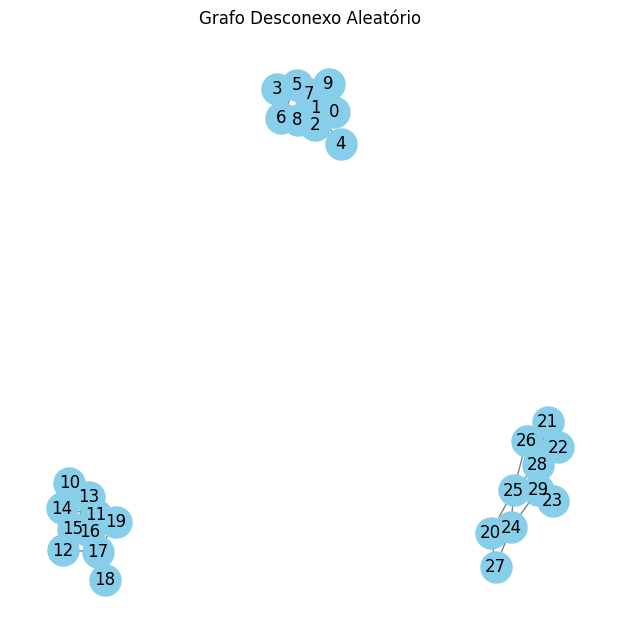

In [24]:
# Gerar um grafo desconexo aleatório
# Aqui, usamos dois componentes desconexos: dois grafos Erdős-Rényi independentes
G1 = nx.erdos_renyi_graph(n=10, p=0.5)  # Primeiro componente
G2 = nx.erdos_renyi_graph(n=10, p=0.5)  # Segundo componente
G3 = nx.erdos_renyi_graph(n=10, p=0.5)  # Segundo componente

# Unir os dois grafos em um grafo desconexo
G = nx.disjoint_union(G1, G2)
G = nx.disjoint_union(G, G3)

# Plotar o grafo desconexo
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Desconexo Aleatório")
plt.show()

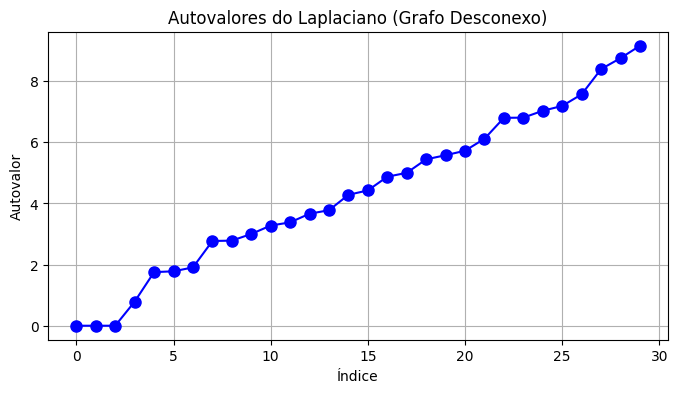

Autovalores do Laplaciano (Grafo Desconexo):
 [-2.39511102e-15  4.44089210e-16  7.48283077e-16  7.87230444e-01
  1.75244494e+00  1.77979460e+00  1.90674662e+00  2.77045443e+00
  2.78320619e+00  3.00000000e+00  3.27582922e+00  3.38012109e+00
  3.66306389e+00  3.77731608e+00  4.28137343e+00  4.42522827e+00
  4.87292181e+00  5.00000000e+00  5.44163329e+00  5.57632430e+00
  5.72282890e+00  6.11451500e+00  6.79842478e+00  6.80487740e+00
  7.02997724e+00  7.18786847e+00  7.56755213e+00  8.39311592e+00
  8.75044816e+00  9.15670338e+00]


In [25]:
# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Calcular autovalores (Lambda) e autovetores (U)
eigenvalues, eigenvectors = np.linalg.eigh(L)  # Use eigh para Laplaciano simétrico

# Criar a matriz diagonal Lambda com os autovalores
Lambda = np.diag(eigenvalues)

# Plotar os autovalores
plt.figure(figsize=(8, 4))
plt.plot(np.sort(eigenvalues), 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano (Grafo Desconexo)")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

# Mostrar os autovalores
print("Autovalores do Laplaciano (Grafo Desconexo):\n", np.sort(eigenvalues))

### Autovalor de Fiedler

Uma propriedade interessante da matriz Laplaciana que pode ser ilustrada com código é a conexão entre o segundo menor autovalor (chamado autovalor de Fiedler) e a conectividade do grafo. Esse autovalor está relacionado à dificuldade de "separar" o grafo em subcomponentes, ou seja, ele indica a robustez da conectividade do grafo. Grafos com um pequeno segundo autovalor tendem a ser menos conectados ou mais fáceis de "quebrar" em duas partes.

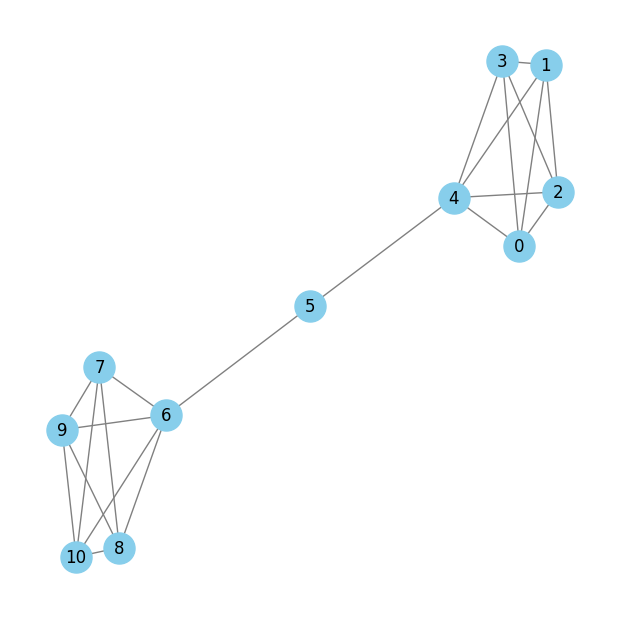

In [26]:
# Criar um grafo com duas comunidades conectadas fracamente
G = nx.barbell_graph(5, 1)  # Dois cliques de 5 nós, conectados por uma única aresta

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.show()

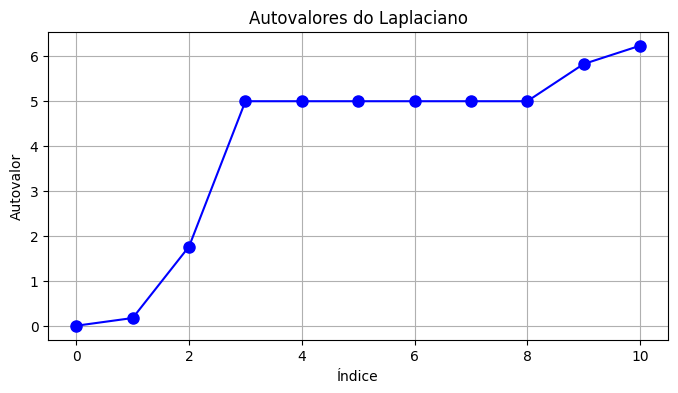

In [27]:
# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Calcular autovalores e autovetores
eigenvalues, eigenvectors = np.linalg.eig(L)
sorted_eigenvalues = np.sort(eigenvalues)

# Plotar os autovalores
plt.figure(figsize=(8, 4))
plt.plot(sorted_eigenvalues, 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

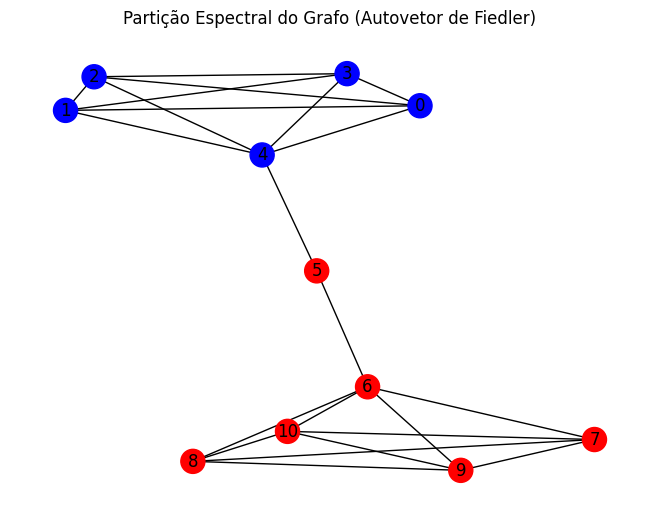

In [28]:
# Autovetor correspondente ao segundo menor autovalor (autovetor de Fiedler)
fiedler_vector = eigenvectors[:, np.argsort(eigenvalues)[1]]

# Partição dos nós baseada no sinal do autovetor de Fiedler
partition = np.sign(fiedler_vector)

# Visualizar a partição do grafo
colors = ['red' if partition[i] < 0 else 'blue' for i in range(len(partition))]
nx.draw(G, node_color=colors, with_labels=True)
plt.title("Partição Espectral do Grafo (Autovetor de Fiedler)")
plt.show()

### Laplaciano e média dos vizinhos

A matriz Laplaciana $L$ tem uma propriedade interessante que pode ser expressa da seguinte forma:

$$
[Lx]_i = [(D - A)x]_i = \sum_j A_{ij}(x_i - x_j)
$$

Essa equação mostra como a Laplaciana captura as diferenças entre o valor de $x$ no nó $i$ e seus vizinhos $j$. Para cada nó $i$, o valor de $[Lx]_i$ é a soma das diferenças $(x_i - x_j)$ ponderada pelas arestas $A_{ij}$ entre $i$ e $j$.

__Isso nos diz porque o Laplaciano tem as propriedades anteriores e nos dá uma dica da sua relação com convolução__

### Interpretação:
- Se o grafo for **conectado**, ou seja, todos os nós estão ligados de alguma forma, os autovetores associados a autovalores pequenos (especialmente o autovetor de Fiedler) tendem a suavizar essas diferenças. Quando $x$ representa uma função em um grafo (como uma posição, uma temperatura ou outro atributo), $Lx$ mede o quanto essa função varia ao longo das arestas.
- Quando $x$ for constante em toda a vizinhança de um nó, então $[Lx]_i = 0$. Por isso, a Laplaciana é uma medida da **variação local** no grafo. Se $x$ varia muito entre os vizinhos, $[Lx]_i$ será grande, o que significa que o valor de $x$ é menos "suave" ao longo do grafo.

Essa propriedade é útil em aplicações de **suavização** e **propagação de rótulos** em grafos, onde procuramos minimizar variações bruscas nos valores atribuídos aos nós, favorecendo distribuições suaves entre nós conectados.

### Laplaciano e Convolução

Se temos um espaço de Hilbert $\mathcal{H}$ e uma base ortonormal $\{u_i\}_{i=1}^\infty$, então, dado $x \in \mathcal{H}$:
$$ \{\langle x, u_i \rangle\}_{i=1}^\infty $$
são os coeficientes de Fourier dado a base em questão, e:
$$ \sum \langle x, u_i \rangle u_i \to x. $$

Vamos definir a transformada de Fourier dessa forma:

$$ \mathcal{F}[x][\ell] = \hat{x}_\ell = \langle x, u_\ell \rangle $$

### Em grafos...

No nosso caso, como podemos decompor $\mathcal{L}$:

$$\mathcal{L} = U \Lambda U^{-1} = U \Lambda U^{\top},$$

Em forma matricial, isso é igual a:
$$ \hat{x} = U^T x. $$

De forma similar, sua inversa é:
$$ x = U \hat{x}. $$

Em resumo, a transformada de Fourier no grafo utiliza os autovetores da matriz laplaciana para permitir a representação de um sinal em dois domínios distintos: o domínio dos vértices e o domínio espectral do grafo. No domínio espectral, podemos aplicar operações análogas às convoluções tradicionais em sinais (como em séries temporais ou imagens), filtrando ou transformando o sinal de forma mais controlada e adaptada à estrutura do grafo.

### Convolução no Domínio Espectral

A convolução em grafos pode ser descrita no domínio espectral da seguinte maneira. Sabemos que a transformada de Fourier da convolução de dois sinais $y$ e $x$ é dada por:

$$ \mathcal{F}[y*x] = \mathcal{F}[y] \odot \mathcal{F}[x], $$

onde $\odot$ representa a multiplicação ponto a ponto. Logo,

$$ y*x =  \mathcal{F}^{-1}[\mathcal{F}[y] \odot \mathcal{F}[x]]. $$

Pela análise acima, isso é equivalente a:

$$ y*x =  U(U^T y \odot U^T x). $$

__COOL!!!__

Isso pode ser reescrito como:

$$ y*x =  U y_\theta(\Lambda) U^T x, $$

onde

$$ y_\theta(\Lambda) = \text{diag}(U^T y). $$

Além disso, note que para qualquer $\theta$:

$$ U^Ty = \theta \Leftrightarrow y = U\theta$$

Dessa forma, a **convolução espectral** de $x$ com $y$ é dada por:

$$ y*x = U y_\theta(\Lambda)U^T x, $$

onde

$$ y_\theta(\Lambda) = \text{diag}([\theta_1,\dots,\theta_n]) = 
\begin{pmatrix}
\theta_1 & 0 & 0 & \dots & 0 \\
0 & \theta_2 & 0 & \dots & 0 \\
0 & 0 & \theta_3 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & \theta_n
\end{pmatrix} $$

são os valores $\theta$ que serão aprendidos pelo modelo.

### Interpretação

Nessa fórmula, $y_\theta(\Lambda)$ representa um filtro espectral que é parametrizado pelos valores $\theta$. Em redes neurais convolucionais de grafos (GCNs), o objetivo é aprender esses valores $\theta$ para que o filtro possa capturar as propriedades relevantes do grafo no domínio espectral. Essa convolução permite que a informação seja agregada de maneira eficiente entre os vértices, levando em consideração a estrutura topológica do grafo.

A convolução espectral é fundamental em modelos de aprendizado em grafos, pois permite realizar operações análogas às convoluções em imagens, mas de forma adaptada à natureza irregular dos grafos.

### GCN de uma camada usando $y_\theta(\Lambda)$

A fórmula para uma Graph Convolutional Network (GCN) de uma única camada é dada por:

$$
H^{(1)} = \sigma \left( U y_\theta(\Lambda) U^T X \right)
$$

Onde:
- $X$ é a matriz de características dos nós (dimensão $n \times d$, onde $n$ é o número de nós e $d$ é o número de características de entrada).
- $U$ são os autovetores da matriz Laplaciana $\mathcal{L}$.
- $y_\theta(\Lambda)$ é a matriz de parâmetros a serem aprendidos, com $\theta_1, \dots, \theta_n$ na diagonal.
- $\sigma$ é uma função de ativação (como ReLU, sigmoid, etc.).
- $H^{(1)}$ é a saída da primeira camada.


### Dificuldades de Usar $y_\theta(\Lambda)$ na Prática

1. **Custo Computacional**: A convolução espectral, como definida por $H^{(1)} = \sigma \left( U y_\theta(\Lambda) U^T X \right)$, requer a decomposição espectral da matriz Laplaciana $\mathcal{L}$, ou seja, o cálculo de seus autovetores $U$. Isso é computacionalmente caro, especialmente para grandes grafos, já que a decomposição espectral custa $\mathcal{O}(n^3)$, onde $n$ é o número de nós do grafo.
   
2. **Dependência Global**: A transformação envolve toda a matriz de autovetores $U$, o que implica que a convolução não é local. Em grafos, espera-se que a convolução aproveite apenas a vizinhança local de um nó, mas essa definição envolve a estrutura global do grafo.

3. **Escalabilidade**: Devido ao custo computacional e à necessidade de armazenar grandes matrizes $U$ e $y_\theta(\Lambda)$, aplicar essa abordagem diretamente em grandes redes torna-se inviável em termos de memória e tempo de execução.


### Simplificação com Polinômios de Chebyshev

Uma adaptação comum para simplificar a convolução espectral é aproximar o filtro espectral $y_\theta(\Lambda)$ usando **polinômios de Chebyshev**. Essa abordagem elimina a necessidade de calcular explicitamente a decomposição espectral da Laplaciana. 

__INTUIÇÃO:__ Vamos considerar:

$$ y_\theta(\Lambda) = \sum^k \theta_k \Lambda^k $$

Isto é, um polinômio com respeito aos autovalores da matriz Laplaciana. Dessa forma, a convolução espectral pode ser escrita como:

$$ y*x \approx U \left(\sum^k \theta_k \Lambda^k \right) U^T x = \sum^k \theta_k L^k x $$

Isso significa que, ao invés de lidar diretamente com os autovalores $\Lambda$ da matriz Laplaciana, podemos aplicar diretamente potências da matriz Laplaciana $L$. 

#### Benefícios dessa Simplificação

1. **Eficiência Computacional**: Ao aproximar o filtro espectral com polinômios de Chebyshev, evitamos o cálculo caro dos autovetores de $\mathcal{L}$. A convolução pode ser feita diretamente no domínio dos nós, utilizando $L^k$, o que reduz o custo para $\mathcal{O}(n \cdot |E|)$, onde $|E|$ é o número de arestas.
   
2. **Convolução Local**: O uso de polinômios garante que a convolução considere apenas as vizinhanças locais dos nós, já que cada termo $L^k x$ envolve apenas os $k$-ésimos vizinhos. Isso torna a convolução mais alinhada com o comportamento esperado de redes convolucionais.

3. **Escalabilidade**: Ao aplicar diretamente $L^k$, conseguimos realizar a convolução em grafos muito grandes, sem a necessidade de armazenar ou calcular autovalores ou autovetores, garantindo escalabilidade para grafos com milhões de nós.


### Simplificação de Kipf para Aproximação de Ordem 2

Para reduzir a complexidade computacional da convolução espectral em grafos, [__Kipf e Welling__](https://arxiv.org/pdf/1609.02907) propuseram uma simplificação, aproximando a convolução polinomial com um **polinômio de ordem 2**. Em vez de considerar potências mais altas da matriz Laplaciana, eles sugeriram usar apenas $k = 2$, o que envolve os vizinhos até a segunda ordem (ou seja, os vizinhos dos vizinhos).

#### Passo 1: Normalização da Laplaciana
Em vez de utilizar diretamente a matriz Laplaciana $L$, utilizamos a matriz de adjacência normalizada $\tilde{A}$, que é definida como:

$$
\tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}},
$$

onde $D$ é a matriz diagonal de graus dos nós, e $A$ é a matriz de adjacência. A normalização garante uma melhor propagação da informação ao balancear as contribuições de nós com diferentes graus.

#### Passo 2: Inclusão de Auto-Laços
Para garantir que cada nó também considere sua própria informação, adicionamos uma identidade à matriz de adjacência normalizada. Isso cria auto-laços no grafo:

$$
\hat{A} = \tilde{A} + I,
$$

onde $I$ é a matriz identidade. Dessa forma, além de considerar os vizinhos diretos e os vizinhos de vizinhos (grau 2), cada nó também leva em conta sua própria característica.

#### Passo 3: Convolução de Ordem 2
Com essa aproximação, a convolução espectral de ordem 2 pode ser expressa como (isso é uma conta no artigo de Kipf e Welling):

$$
H^{(l+1)} = \sigma \left( \hat{A} H^{(l)} W^{(l)} \right),
$$

onde:
- $H^{(l)}$ é a matriz de características dos nós na camada $l$ (com $H^{(0)} = X$, a matriz de características de entrada).
- $W^{(l)}$ são os pesos aprendidos na camada $l$.
- $\hat{A}$ é a matriz de adjacência normalizada com auto-laços.
- $\sigma$ é a função de ativação (por exemplo, ReLU).
- $H^{(l+1)}$ é a matriz de características na próxima camada.

#### Por que $k = 2$ é suficiente?

Ao utilizar $k = 2$ na aproximação da convolução, estamos considerando os vizinhos diretos e os vizinhos de vizinhos de cada nó, o que captura informações locais suficientes para a maioria das tarefas em grafos. Em muitos cenários, a influência de nós muito distantes tende a ser menos relevante. Além disso, a convolução de ordem 2 preserva uma boa quantidade de estrutura local do grafo e evita a complexidade de cálculos com potências mais altas da Laplaciana, mantendo a eficiência.

Essa simplificação se baseia na ideia de que, em muitos grafos reais, a informação relevante para predição está nos nós próximos (dentro de um raio pequeno). Por isso, potências mais altas, que levariam em conta vizinhos muito distantes, podem introduzir ruído ou desnecessariamente aumentar o custo computacional.

### Forma Final da GCN de Uma Camada

Usando essa simplificação, a fórmula de uma Graph Convolutional Network (GCN) de uma única camada pode ser escrita como:

$$
H^{(1)} = \sigma \left( \hat{A} X W \right),
$$

onde:
- $X$ é a matriz de características dos nós,
- $W$ são os pesos que serão aprendidos,
- $\hat{A}$ é a matriz de adjacência normalizada com auto-laços.

Essa fórmula representa uma convolução local, levando em conta tanto os vizinhos diretos quanto os vizinhos de vizinhos (ordem 2), sem precisar calcular potências mais altas da matriz Laplaciana.

### Conclusão

A simplificação de Kipf aproxima a convolução espectral com um polinômio de ordem 2, capturando a estrutura local do grafo de forma eficiente. Isso elimina a necessidade de calcular autovalores ou autovetores, tornando a GCN escalável e prática para grandes grafos.


## Aplicação: Cora Dataset

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

In [2]:
# Load Cora dataset
dataset = Planetoid(root='/tmp/cora', name='Cora')

Processing...
Done!


In [22]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) 
        self.dropout_rate = dropout_rate
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Apply ReLU activation function after conv1
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Apply dropout after conv1
        x = self.conv2(x, edge_index)  # Apply the second GCN layer
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  # App
        return F.log_softmax(x, dim=1)


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=32).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [24]:
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [25]:
out = model(data.x, data.edge_index)
out[data.train_mask].shape
data.y[data.train_mask].shape

torch.Size([140])

In [26]:
import matplotlib.pyplot as plt

# Listas para armazenar os valores de perda e acurácia
train_losses = []
test_losses = []
test_accuracies = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return loss.item(), acc

n_epoch = 1000
# Loop de treinamento e teste
for epoch in range(1, n_epoch):
    train_loss = train()
    test_loss, acc = test()
    
    # Armazenando os valores
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(acc)
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 001, Train Loss: 1.9400, Test Loss: 1.8970, Accuracy: 0.2150
Epoch: 002, Train Loss: 1.8338, Test Loss: 1.8177, Accuracy: 0.3140
Epoch: 003, Train Loss: 1.6632, Test Loss: 1.7203, Accuracy: 0.5140
Epoch: 004, Train Loss: 1.5599, Test Loss: 1.6153, Accuracy: 0.6680
Epoch: 005, Train Loss: 1.4204, Test Loss: 1.5104, Accuracy: 0.7450
Epoch: 006, Train Loss: 1.4004, Test Loss: 1.4155, Accuracy: 0.7780
Epoch: 007, Train Loss: 1.2188, Test Loss: 1.3258, Accuracy: 0.7880
Epoch: 008, Train Loss: 1.1535, Test Loss: 1.2465, Accuracy: 0.7950
Epoch: 009, Train Loss: 1.1103, Test Loss: 1.1745, Accuracy: 0.7970
Epoch: 010, Train Loss: 1.0038, Test Loss: 1.1109, Accuracy: 0.7970
Epoch: 011, Train Loss: 0.9370, Test Loss: 1.0506, Accuracy: 0.7990
Epoch: 012, Train Loss: 0.9482, Test Loss: 1.0035, Accuracy: 0.7920
Epoch: 013, Train Loss: 0.9057, Test Loss: 0.9497, Accuracy: 0.7950
Epoch: 014, Train Loss: 0.9564, Test Loss: 0.8992, Accuracy: 0.7970
Epoch: 015, Train Loss: 0.8365, Test Loss: 0.852

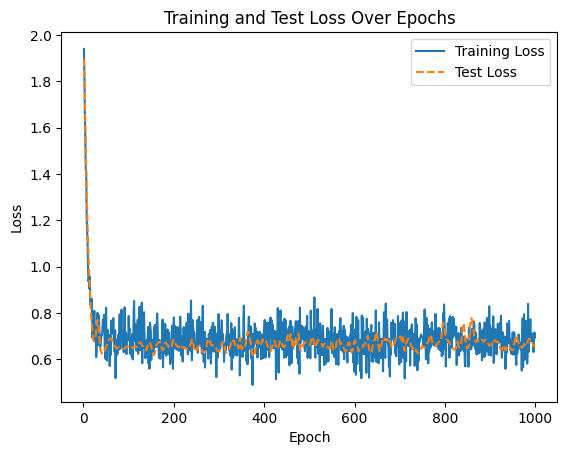

In [27]:
# Plotando as curvas de perda
epochs = range(1, n_epoch)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

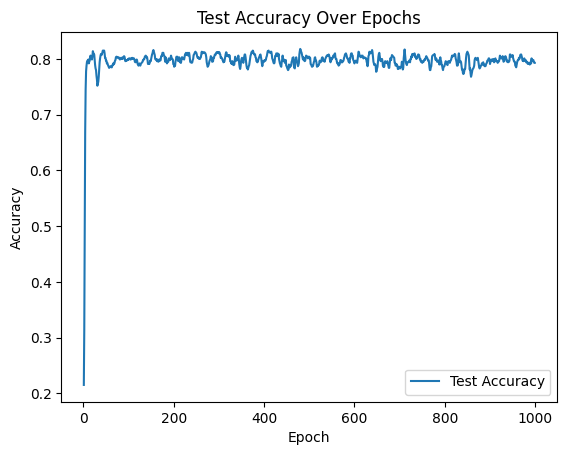

In [28]:
# Plotando a curva de acurácia
plt.figure()
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

### t-sne Embedding

In [29]:
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

In [30]:
    embeddings.shape

torch.Size([2708, 7])

In [31]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels):
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    
    # Plotando
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Cora Embeddings")
    plt.show()

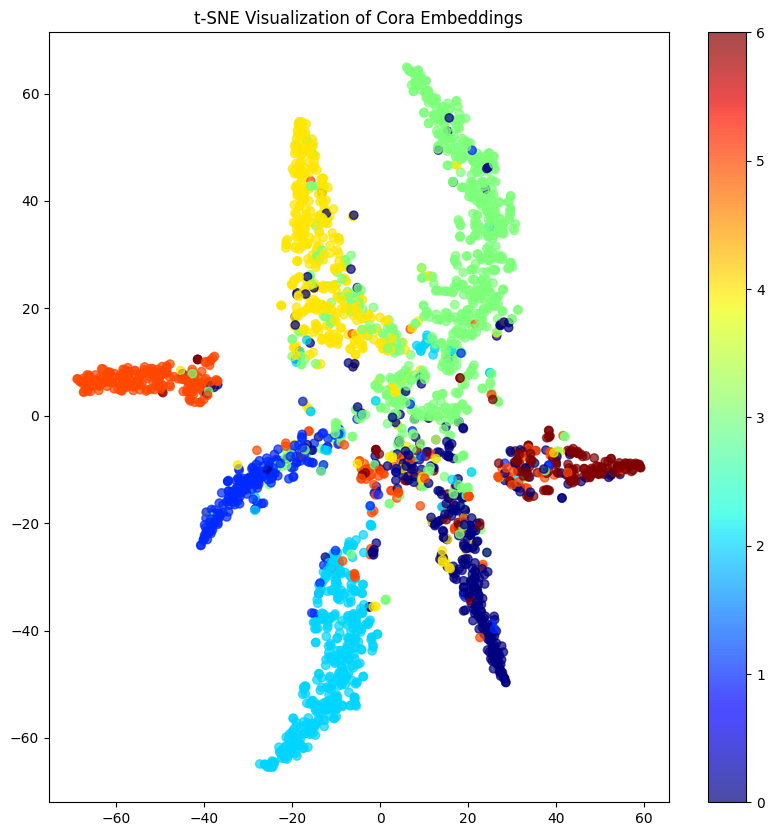

In [32]:
plot_tsne(embeddings, data.y.cpu())